# Read file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

import torch.nn.functional as F
from src.utils import *
from src.datatype import *
from src.renderer import *

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from tqdm import tqdm
import time

In [7]:
UR = UltrasoundRenderer(100, 0.1)

In [8]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
volume = dataset[0]["image"].squeeze(0)

# Plotting

tensor([1400509.3750, 1400382.0000, 1400382.0000, 1400382.0000, 1400382.0000,
        1400382.0000, 1400509.3750, 1400509.3750, 1400636.6250, 1400764.0000,
        1400891.3750, 1400891.3750, 1400764.0000, 1400764.0000, 1400636.6250,
        1400636.6250, 1400509.3750, 1400382.0000, 1400382.0000, 1400382.0000,
        1400382.0000, 1400636.6250, 1401018.6250, 1401528.0000, 1402037.3750,
        1402037.3750, 1401400.6250, 1404711.3750, 1414388.6250, 1428395.6250,
        1448896.3750, 1464303.8750, 1471944.0000, 1475636.6250, 1473344.6250,
        1474490.6250, 1480857.3750, 1486460.1250, 1491298.6250, 1494100.1250,
        1493590.8750, 1491808.1250, 1487860.8750, 1477928.7500, 1458064.6250,
        1437945.6250, 1417445.0000, 1405093.3750, 1406112.0000, 1410696.1250,
        1421137.5000, 1430432.8750, 1437691.0000, 1442784.3750, 1444312.3750,
        1446604.3750, 1450042.5000, 1449915.1250, 1443930.3750, 1434762.2500,
        1420119.0000, 1412096.7500, 1415025.5000, 1420246.1250, 

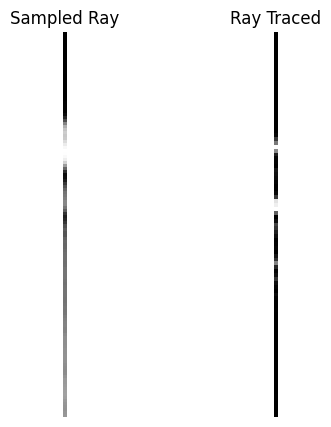

In [118]:
# sample volume 
sample_ray = volume[128,128,0:128].unsqueeze(0)

ray_one = UR.simulate_ray(
    volume,
    torch.tensor([128.,128.,0.]),
    torch.tensor([0.,0.,1.]),
    
).unsqueeze(0)

fig, ax = plt.subplots(1, 2, figsize=(5, 5))

ax[0].imshow(sample_ray.cpu().numpy().T, cmap="gray")
ax[0].set_title("Sampled Ray")
ax[0].axis("off")

ax[1].imshow(ray_one.cpu().numpy().T, cmap="gray")
ax[1].set_title("Ray Traced")
ax[1].axis("off")
plt.show()

Starting simulation...
Simulation took 0.00 seconds.


C:\Users\noe\AppData\Local\Temp\ipykernel_73584\664046919.py:41: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Simulation took 3.61 seconds.
Simulation took 3.62 seconds.
Simulation took 3.62 seconds.
No axis provided, creating a new one.


C:\Users\noe\AppData\Local\Temp\ipykernel_73584\664046919.py:72: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



<Axes: title={'center': 'Fan-shaped Ultrasound Frame'}>

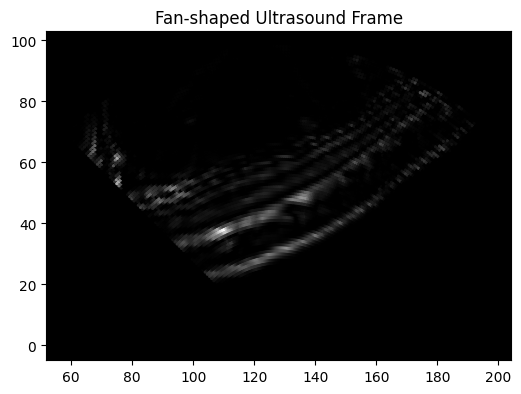

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_fan(
    angle: int = 45,
    rays: int = 128,
    source: np.ndarray = np.array([128., 128., 0.]),
    ax: plt.Axes = None,
    time_it : bool = False,
) -> plt.Axes:
    """
    Plots a simulated ultrasound fan frame.
    
    Args:
        angle: Total angular spread of the fan (degrees)
        rays: Number of rays in the fan
        source: Source position (numpy array of shape (3,))
        ax: Matplotlib axis to plot on (optional)
    """
    # 1. Create ray directions (vectorized)
    if time_it:
        start_time = time.time()
        print("Starting simulation...")
    
    thetas = np.radians(np.linspace(-angle, angle, rays))  # shape (rays,)
    directions = np.stack([
        np.sin(thetas),            # x
        np.zeros_like(thetas),     # y
        np.cos(thetas)             # z
    ], axis=-1)                   # shape (rays, 3)

    if time_it:
        elapsed_time = time.time() - start_time
        print(f"Simulation took {elapsed_time:.2f} seconds.")
    

    # 2. Simulate frame
    sim_framed = UR.simulate_frame(
        volume=volume,
        source=torch.tensor(source, dtype=torch.float32),
        directions=torch.tensor(directions, dtype=torch.float32),
    )

    if time_it:
        elapsed_time = time.time() - start_time
        print(f"Simulation took {elapsed_time:.2f} seconds.")
    
    # 3. Convert to numpy
    frame_np = sim_framed.detach().cpu().numpy()  # shape (rays, samples)
    n_rays, n_samples = frame_np.shape

    if time_it:
        elapsed_time = time.time() - start_time
        print(f"Simulation took {elapsed_time:.2f} seconds.")

    # 4. Compute points for each ray and distance (vectorized)
    ray_indices = np.arange(n_samples)  # (samples,)
    directions_xz = np.stack([
        np.sin(thetas), 
        np.cos(thetas)
    ], axis=1)  # shape (rays, 2) for (x, z) directions only

    if time_it:
        elapsed_time = time.time() - start_time
        print(f"Simulation took {elapsed_time:.2f} seconds.")
    
    # Expand to (rays, samples, 2)
    directions_xz = directions_xz[:, None, :]    # (rays, 1, 2)
    ray_indices = ray_indices[None, :, None]     # (1, samples, 1)

    points = source[[0, 2]][None, None, :] + ray_indices * directions_xz  # (rays, samples, 2)

    x_coords = points[..., 0].flatten()
    z_coords = points[..., 1].flatten()
    intensities = frame_np.flatten()

    # 5. Plot
    if ax is None:
        print("No axis provided, creating a new one.")
        fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(x_coords, z_coords, c=intensities, cmap='gray', s=2)
    ax.set_facecolor('black')
    ax.set_title("Fan-shaped Ultrasound Frame")
    ax.set_aspect('equal')

    return ax

plot_fan(angle=45, rays=150, source=torch.tensor([128., 90.,0.]))

Starting simulation...
Simulation took 0.00 seconds.


C:\Users\noe\AppData\Local\Temp\ipykernel_73584\664046919.py:41: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Simulation took 3.57 seconds.
Simulation took 3.57 seconds.
Simulation took 3.57 seconds.
Starting simulation...
Simulation took 0.00 seconds.


C:\Users\noe\AppData\Local\Temp\ipykernel_73584\664046919.py:72: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



Simulation took 3.55 seconds.
Simulation took 3.55 seconds.
Simulation took 3.55 seconds.
Starting simulation...
Simulation took 0.00 seconds.
Simulation took 3.68 seconds.
Simulation took 3.68 seconds.
Simulation took 3.68 seconds.


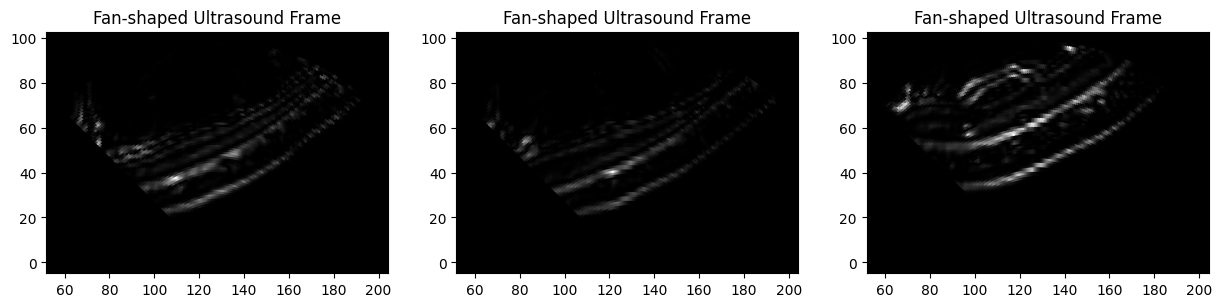

In [128]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
plot_fan(angle=45, rays=150, source=torch.tensor([128., 90.,0.]), ax=ax[0])
plot_fan(angle=45, rays=150, source=torch.tensor([128., 110.,0.]), ax=ax[1])
plot_fan(angle=45, rays=150, source=torch.tensor([128., 200.,0.]), ax=ax[2])
plt.show()

In [55]:
angle = 45  # degrees
rays = 128

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

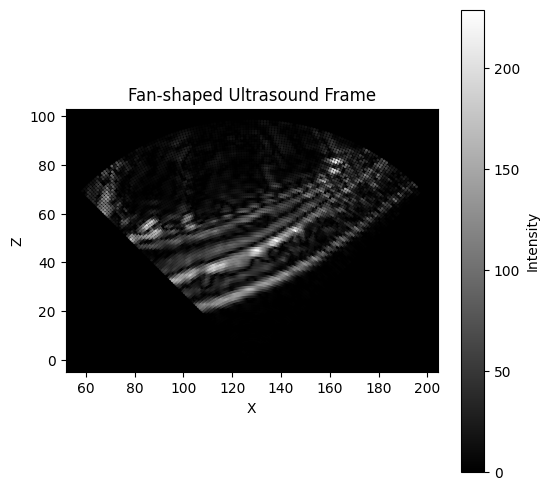

In [57]:
sim_framed = UR.simulate_frame(
    volume=volume,
    source=torch.tensor([128.,128.,0.]),
    directions=torch.tensor(directions, dtype=torch.float32),
)

frame_np = sim_framed.detach().cpu().numpy()
n_rays, n_samples = frame_np.shape
source = np.array([128, 0])  # (x, z) — assuming 2D for display

# Scale ray length to match sample count
ray_len = n_samples
thetas = np.radians(np.linspace(-angle, angle, n_rays))

x_coords = []
z_coords = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(frame_np[i, r])

# Create scatter plot with intensity
plt.figure(figsize=(6, 6))
plt.rcParams['axes.facecolor'] = 'black'

plt.scatter(x_coords, z_coords, c=intensities, cmap='gray', s=1)
plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Fan-shaped Ultrasound Frame")
plt.colorbar(label="Intensity")
plt.show()


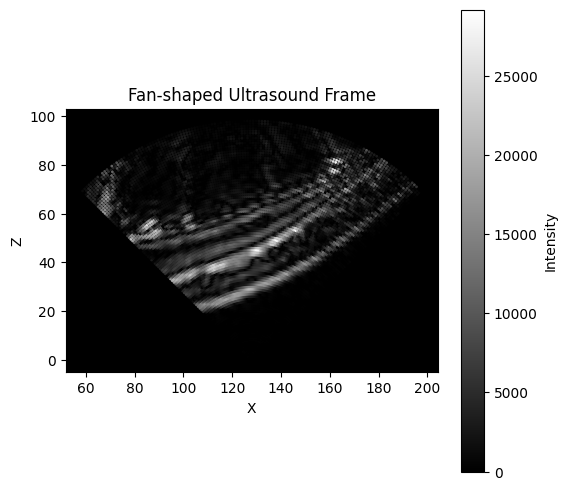

In [ ]:

sim_framed = UR.simulate_frame(
    volume=volume,
    source=torch.tensor([128.,128.,0.]),
    directions=torch.tensor(directions, dtype=torch.float32),
)

frame_np = sim_framed.detach().cpu().numpy()
n_rays, n_samples = frame_np.shape
source = np.array([128, 0])  # (x, z) — assuming 2D for display

# Scale ray length to match sample count
ray_len = n_samples
thetas = np.radians(np.linspace(-angle, angle, n_rays))

x_coords = []
z_coords = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(frame_np[i, r])

# Create scatter plot with intensity
plt.figure(figsize=(6, 6))
plt.rcParams['axes.facecolor'] = 'black'

plt.scatter(x_coords, z_coords, c=intensities, cmap='gray', s=1)
plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Fan-shaped Ultrasound Frame")
plt.colorbar(label="Intensity")
plt.show()


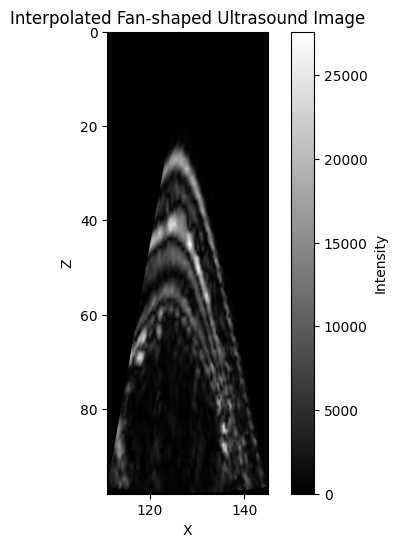

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming sim_framed has shape (num_rays, num_samples)
frame_np = sim_framed.detach().cpu().numpy()
n_rays, n_samples = frame_np.shape

# Define source and angle range
source = np.array([128, 0])  # (x, z)
thetas = np.radians(np.linspace(-10, 10, n_rays))
ray_len = n_samples

# Convert polar coordinates (r, theta) → (x, z)
x_coords = []
z_coords = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(frame_np[i, r])

x_coords = np.array(x_coords)
z_coords = np.array(z_coords)
intensities = np.array(intensities)

# Create a dense grid for interpolation
grid_x, grid_z = np.meshgrid(
    np.linspace(x_coords.min(), x_coords.max(), 512),
    np.linspace(z_coords.min(), z_coords.max(), 512)
)

# Interpolate intensity onto the grid
grid_intensity = griddata(
    points=(x_coords, z_coords),
    values=intensities,
    xi=(grid_x, grid_z),
    method='linear',
    fill_value=0.0
)

# Plot the interpolated fan image
plt.figure(figsize=(6, 6))
plt.imshow(
    grid_intensity,
    extent=(x_coords.min(), x_coords.max(), z_coords.max(), z_coords.min()),  # flip z to look like real US
    cmap='gray',
    aspect='equal'
)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Interpolated Fan-shaped Ultrasound Image")
plt.colorbar(label="Intensity")
plt.show()


# Accelerate the simulation 

In [9]:
import timeit

In [10]:
UR = UltrasoundRenderer(100, 0.1)

In [11]:
# apply timeit to UR.compute_reflection_coeff
def timeit_UR_compute_reflection_coeff():
    return UR.compute_reflection_coeff(
        Z1=torch.randn(128, 128),
        Z2=torch.randn(128, 128),
    )

execution_time = timeit.timeit(timeit_UR_compute_reflection_coeff, number=1000) / 1000
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.0002 seconds


Optimisation fix: scale/process volume _outside_ of the trace ray function

In [13]:
def timeit_UR_trace_ray():
    return UR.trace_ray(
        volume=volume,
        source=torch.tensor([128., 128., 0.]),
        direction=torch.tensor([0.0,0.0,1.0]),
        num_samples=100,
    )

execution_time = timeit.timeit(timeit_UR_trace_ray, number=1000) / 1000
print(f"Execution time: {execution_time:.4f} seconds")
# plt.imshow(ray_one.cpu().numpy(), cmap="gray")

<string>:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Execution time: 0.0041 seconds


Next hurdle: simulate frame rendering over a loop

In [16]:
directions = [torch.tensor(d, dtype=torch.float32) for d in directions]

In [17]:
s = torch.tensor([128.0, 128.0, 0])
d = torch.tensor([0.0, 0.0, 1.0])

In [18]:
ground_truth = UR.simulate_frame(
    volume=volume,
    source=s,
    directions=directions,
)

In [19]:
def timeit_UR_simulate_frame():
    return UR.simulate_frame(
        volume=volume,
        source=s,
        directions=directions)

execution_time = timeit.timeit(timeit_UR_simulate_frame, number=10) / 10
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.5305 seconds


In [241]:
test_f  = torch.stack([UR.simulate_ray(
    volume=volume,
    source=s,
    direction=d,
) for d in directions
], dim=0)

<string>:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(True)

I need to optimisie it by optimising the simulate_ray function.

In [116]:
def trace_rays(
        volume: torch.Tensor, 
        source: torch.Tensor, 
        directions: torch.Tensor, 
        num_samples: int) -> torch.Tensor:
    """
    Simulates ray tracing through a 3D volume using batched grid_sample.
    
    Args:
        volume: (D, H, W) Tensor of acoustic properties (e.g., normalized impedance)
        source: (3,) Tensor for the starting point of rays
        directions: (N_rays, 3) Tensor of ray directions (must be unit vectors)
        num_samples: int, number of steps along each ray
        
    Returns:
        R: (N_rays, num_samples-1) Tensor of reflection coefficients along each ray
    """
    # housekeeping
    if directions.ndim == 1:
        directions = directions.unsqueeze(0)
    Z = (volume - volume.min()) / (volume.max() - volume.min())
    Z = Z * (1.7e6 - 1.4e6) + 1.4e6

    D, H, W = volume.shape

    # Prepare steps and directions
    steps = torch.arange(0, num_samples, dtype=torch.float32, device=volume.device).view(1, -1, 1)  # (1, num_samples, 1)
    directions = directions.unsqueeze(1)  # (N_rays, 1, 3)

    # Trace points
    points = source + steps * directions 

    grid = torch.empty_like(points, dtype=torch.float32)

    
    grid[..., 0] = 2 * (points[..., 2] / max(D - 1, 1)) - 1  # z → x
    grid[..., 1] = 2 * (points[..., 1] / max(H - 1, 1)) - 1  # y → y
    grid[..., 2] = 2 * (points[..., 0] / max(W - 1, 1)) - 1  # x → z

    # Reshape for grid_sample
    # grid = grid.view(-1, -1, 1, 1, 3)  # (N, D_out, H_out, W_out, 3)
    grid = grid.view(-1, num_samples, 1, 1, 3) 

    sampler = Z.unsqueeze(0).unsqueeze(0)
    sampler = sampler.expand(grid.shape[0], -1, -1, -1, -1)

    ray_values = F.grid_sample(
        sampler,
        grid,
        mode='bilinear',
        padding_mode='border',
        align_corners=True,
    ).squeeze()

    return ray_values

def simulate_rays(
        volume: torch.Tensor, 
        source: torch.Tensor, 
        direction: torch.Tensor, 
        num_samples: int) -> torch.Tensor:
    """
    Simulates a single ray tracing through a 3D volume using batched grid_sample.
    
    Args:
        volume: (D, H, W) Tensor of acoustic properties (e.g., normalized impedance)
        source: (3,) Tensor for the starting point of the ray
        direction: (n_rays,3,) Tensor for the ray directions (must be a unit vector)
        num_samples: int, number of steps along the ray
        
    Returns:
        R: (num_samples-1) Tensor of reflection coefficients along the ray
    """
    impedances =  trace_rays(volume, source, direction, num_samples)
    if impedances.ndim == 1:
        impedances = impedances.unsqueeze(0)
    Z1 = impedances[:, :-1]  # (num_samples-1)
    Z2 = impedances[:, 1:]   # (num_samples-1)

    R = UR.compute_reflection_coeff(Z1, Z2)
    return R

R = simulate_rays(
    volume=volume,
    source=s,
    direction=torch.stack(directions, dim=0),
    num_samples=100,
)


In [110]:
directions[0].unsqueeze(0).shape

torch.Size([1, 3])

In [101]:
torch.stack([torch.tensor(d, dtype=torch.float32) for d in [directions[0]]]).shape

C:\Users\noe\AppData\Local\Temp\ipykernel_37916\4027748934.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([1, 3])

In [86]:
# TRACE RAYS
Z = (volume - volume.min()) / (volume.max() - volume.min())
Z = Z * (1.7e6 - 1.4e6) + 1.4e6
D, H, W = volume.shape
directions = [torch.tensor(d, dtype=torch.float32) for d in directions]
dir_tensor = torch.stack([torch.tensor(d, dtype=torch.float32) for d in directions], dim=0)
steps = torch.arange(0, UR.num_samples, dtype=torch.float32)

steps = steps.view(1,-1,1)
dir_tensor = dir_tensor.unsqueeze(1)

points = s + steps * dir_tensor

grid = torch.empty_like(points)

grid[..., 0] = 2 * (points[..., 2] / max(D - 1, 1)) - 1  # z → x
grid[..., 1] = 2 * (points[..., 1] / max(H - 1, 1)) - 1  # y → y
grid[..., 2] = 2 * (points[..., 0] / max(W - 1, 1)) - 1  # x → z

# Reshape for grid_sample
# grid = grid.view(-1, -1, 1, 1, 3)  # (N, D_out, H_out, W_out, 3)
grid = grid.view(-1, UR.num_samples, 1, 1, 3) 

sampler = torch.tensor(Z, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
sampler = sampler.expand(grid.shape[0], -1, -1, -1, -1)

ray_values = F.grid_sample(
    sampler.expand(grid.shape[0], -1, -1, -1, -1),
    grid,
    mode='bilinear',
    padding_mode='border',
    align_corners=True,
).squeeze()

# SIMULATE RAY
impedances = ray_values
Z1 = impedances[:,:-1]
Z2 = impedances[:,1:]

R = UR.compute_reflection_coeff(Z1, Z2)

C:\Users\noe\AppData\Local\Temp\ipykernel_37916\1843441430.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_37916\1843441430.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_37916\1843441430.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



<string>:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



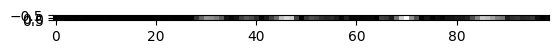

In [99]:
plt.imshow(UR.simulate_ray(
    volume=volume,
    source=s,
    direction=directions[0],
).unsqueeze(0).cpu().numpy(), cmap="gray")

In [131]:
R.shape

torch.Size([128, 99])

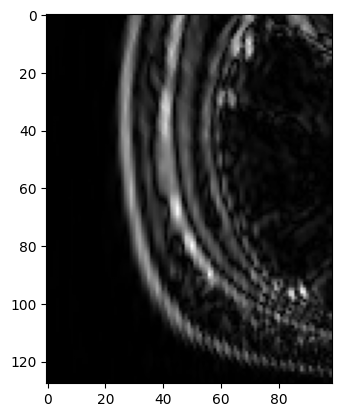

In [117]:
plt.imshow(R, cmap="gray")

In [61]:
torch.isclose(ground_truth,R, atol=1e-5).all()

tensor(False)

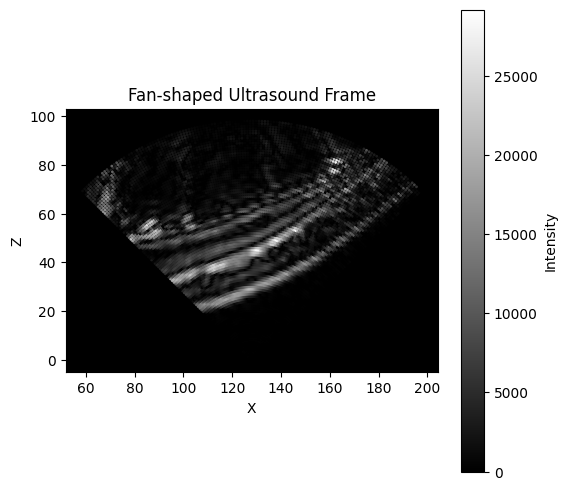

In [ ]:
R = UR.simulate_rays(
    volume=volume,
    source=s,
    directions=torch.stack(directions, dim=0),
)
frame_np = R.detach().cpu().numpy()
n_rays, n_samples = frame_np.shape
source = np.array([128, 0])  # (x, z) — assuming 2D for display

# Scale ray length to match sample count
ray_len = n_samples
thetas = np.radians(np.linspace(-angle, angle, n_rays))

x_coords = []
z_coords = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(frame_np[i, r])

# Create scatter plot with intensity
plt.figure(figsize=(6, 6))
plt.rcParams['axes.facecolor'] = 'black'

plt.scatter(x_coords, z_coords, c=intensities, cmap='gray', s=1)
plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Fan-shaped Ultrasound Frame")
plt.colorbar(label="Intensity")
plt.show()

## TESTING SIMULATE RAY

In [159]:
UR4 = UltrasoundRenderer(100, 0.1)

def timet_it_sample_frame_2():
    return UR4.simulate_rays(
        volume=volume,
        source=s,
        directions=torch.stack(directions, dim=0),
    )

execution_time = timeit.timeit(timet_it_sample_frame_2, number=10) / 10
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.0269 seconds


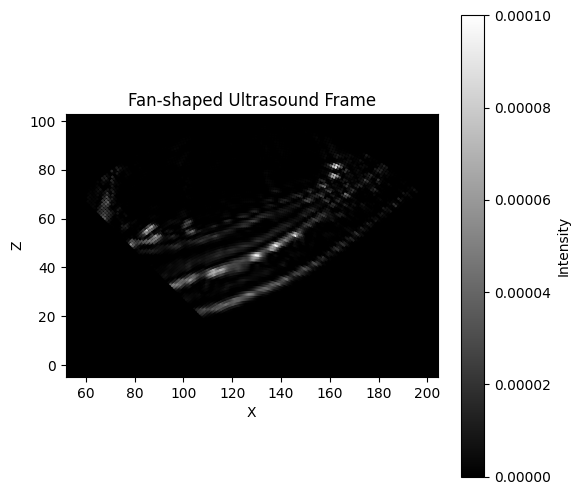

In [160]:
UR4.plot_beam_frame(
    volume=volume,
    source=s,
    directions=torch.stack(directions, dim=0),
    angle=45,
)